In [ ]:

# Download latest version
# path = kagglehub.dataset_download("pedrocouto39/jane-street-market-train-data-best-formats")

# print("Path to dataset files:", path)

In [26]:
import pandas as pd
import polars as pl
import numpy as np
import torch

# Data Preprocessing

In [ ]:
path = "./data/jane_street_train.parquet"
# df = pd.read_feather(path=path)
df = pd.read_parquet(path)
print(df.info())
print(df[:10])

In [ ]:
lf = pl.scan_parquet(path)


In [ ]:
df[:10]

In [ ]:
df[-1:]

In [ ]:
df.head().to_csv()

In [ ]:
np_arr = df.to_numpy()
t = torch.tensor(np_arr)
t.shape

In [5]:
nan_count = np.isnan(t).sum()

In [ ]:
print(nan_count)
print(nan_count/(t.shape[0]*t.shape[1]))

In [7]:
def preprocess(df:pd.DataFrame):
    feature_columns = [c for c in df.columns if c.startswith("feature_")]
    final_target_column = ["resp"]
    target_columns = ["resp_1", "resp_2", "resp_3", "resp_4"]
    all_cols = ["ts_id", "date"] + feature_columns + target_columns + final_target_column

    df = df[all_cols].sort_values(["ts_id", "date"])

    # 3. Pivot so every (ts_id, date) slot exists -------------------------------
    #   (this makes missing dates explicit → NaNs we can ffill / mask)
    dates = np.sort(df.date.unique())
    securities = np.sort(df.ts_id.unique())

    tensor = (
        df.set_index(["ts_id", "date"])
        .reindex(pd.MultiIndex.from_product([securities, dates]))
        .sort_index()
    )

    # 4. Separate inputs & targets ----------------------------------------------
    X = tensor[feature_columns].to_numpy(dtype=np.float32)            # shape (N_sec * N_day, 130)
    y = tensor[target_columns].to_numpy(dtype=np.float32)          # shape (N_sec * N_day, 1)

    # 5. Reshape to (sec, day, chan)
    N_sec, N_day = len(securities), len(dates)
    X = X.reshape(N_sec, N_day, len(feature_columns))
    y = y.reshape(N_sec, N_day, len(target_columns))


### Testing of preprocess 

In [ ]:
df.columns
lst = ["feature_1", "feature_2"]
df[lst]
df.date.unique().shape
df.ts_id.unique().shape

dates = np.sort(df.date.unique())
securities = np.sort(df.ts_id.unique())
tensor = (df.set_index(["date", "ts_id"]))
tensor

In [ ]:
print(pd.to_datetime(946684800+int(df["ts_id"].max()), unit="s"))
print(pd.to_datetime(int(946684800), unit="s"))
15778080*60

In [ ]:
tensor = tensor.reindex(pd.MultiIndex.from_product([securities, dates]))
tensor

In [ ]:
tensor.sort_index()
tensor

### Testing of preprocess COMPLETE

In [ ]:
dict_df = dict(df)
for item in dict_df:
    print(type(dict_df[item]))
    break

In [ ]:
df.info()

In [ ]:
model.module.encoder

In [ ]:
counter = 0
for name, param in model.named_parameters():
    print(name)
    if name == "module.in_proj.weight":
        param.requires_grad = False
    counter += 1
print(counter)


In [29]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

In [30]:
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 20  # prediction length: any positive integer
CTX = 200  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
TEST = 100  # test set length: any positive integer

# Read data into pandas DataFrame
url = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)

# Convert into GluonTS dataset
dct = dict(df)
ds = PandasDataset(dct)

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

# Prepare pre-trained model by downloading model weights from huggingface hub
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

In [ ]:
predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

plot_single(
    inp, 
    label, 
    forecast, 
    context_length=200,
    name="pred",
    show_label=True,
)
plt.show()

# Testing Model

In [2]:
from Julien_Code.Helper.data_processing import Data

data_path = "./data/jane_street_train.parquet"

patch_size = 32                                         # or an int
min_patches = 2

data = Data(data_path, patch_size=patch_size, min_patches=min_patches)
offset = len(data.train_dataset)

🚀 Starting Data Processing Pipeline
📁 Loading data from Parquet file...
🔪 Splitting data at dates: train < 400, val < 450
   Train set: 1878353 rows
   Validation set: 233823 rows
   Test set: 278315 rows
🛠️  Starting preprocessing...
🔍 Step 1: Performing feature selection...
   Dropped 19 highly correlated features.
📊 Step 2: Capping outliers...
📉 Step 3: Removing low-variance features...
   Dropped 0 low-variance features.
📈 Step 4: Applying Z-score standardization...
🎯 Step 5: Creating event flags with a CUSUM filter...


/root/Programming/HAW/Semester/Semester 4/ML2/Praktika/project/Julien_Code/Helper/data_processing.py:126: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['event'] = _cusum_filter(df['resp'].to_numpy(), threshold=3*resp_std_train)
/root/Programming/HAW/Semester/Semester 4/ML2/Praktika/project/Julien_Code/Helper/data_processing.py:126: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['event'] = _cusum_filter(df['resp'].to_numpy(), threshold=3*resp_std_train)
/root/Programming/HAW/Semester/Semester 4/ML2/Praktika/project/Julien_Co

   Final feature count: 112
⏰ Structuring data into time series format...
   Structuring train data...
   Structuring validation data...
   Structuring test data...


/root/Programming/HAW/Semester/Semester 4/ML2/Praktika/project/Julien_Code/Helper/data_processing.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["timestamp"] = (
/root/Programming/HAW/Semester/Semester 4/ML2/Praktika/project/Julien_Code/Helper/data_processing.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["timestamp"] = (


📊 Creating final GluonTS datasets...
✅ Dataset creation complete.


In [3]:
import glob, os, torch
from Julien_Code.Model.finetune import Finetuner                # import your LightningModule
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule    # forecast wrapper
from uni2ts.eval_util.plot import plot_single
from pathlib import Path
from Julien_Code.Helper.dataset import TransformedDataset, AddFreq
from gluonts.dataset.split import split, TestData, OffsetSplitter
from matplotlib import pyplot as plt

In [4]:
size = "small"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [5]:
# 1) pick the checkpoint you want to load
ckpt_dir = "Julien_Code/checkpoints"
ckpt_files = sorted(glob.glob(os.path.join(ckpt_dir, "*.ckpt")), key=os.path.getmtime)
assert ckpt_files, f"No .ckpt files found in {ckpt_dir}"
ckpt_path = ckpt_files[-1]          # newest file  →  change if you prefer another

In [6]:
print(f"Loading fine-tuned checkpoint: {ckpt_path}")

# --------------------------------------------------------------------------- #
# 2) restore the Finetuner
module = MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{size}")
finetuner: Finetuner = Finetuner.load_from_checkpoint(ckpt_path, module=module, map_location=device)
finetuner.eval()                    # we are in inference mode

Loading fine-tuned checkpoint: Julien_Code/checkpoints/last-v2.ckpt
❄️  Frozen 10,868,424/13,827,528 params  ·  Trainable = 3.0 M  (21.40 %)


Finetuner(
  (module): MoiraiModule(
    (mask_encoding): Embedding(1, 384)
    (scaler): PackedStdScaler()
    (in_proj): MultiInSizeLinear(in_features_ls=[8, 16, 32, 64, 128], out_features=384, bias=True, dtype=torch.float32)
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): GroupedQueryAttention(
            (var_attn_bias): BinaryAttentionBias(
              (emb): Embedding(2, 6)
            )
            (time_qk_proj): QueryKeyProjection(
              (query_proj): RotaryProjection()
              (key_proj): RotaryProjection()
            )
            (q_proj): Linear(in_features=384, out_features=384, bias=False)
            (k_proj): Linear(in_features=384, out_features=384, bias=False)
            (v_proj): Linear(in_features=384, out_features=384, bias=False)
            (q_norm): RMSNorm(normalized_shape=(64,), eps=1e-05, weight=True)
            (k_norm): RMSNorm(normalized_shape=(64,), eps=

In [7]:
context_length = 200                                        # context length
prediction_length = 20                                         # prediction length you like
batch_size = 1                                          # batch size
num_samples = 10

# 5. Wrap model for forecasting
# Note: we get feature dimensions from the datasets created by our new Data class
forecast_model = MoiraiForecast(
    module=finetuner.module,
    prediction_length=prediction_length,
    context_length=context_length,
    patch_size=patch_size,
    num_samples=num_samples,
    target_dim=1,  # We are predicting a single target 'resp'
    feat_dynamic_real_dim=data.train_dataset.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=data.train_dataset.num_past_feat_dynamic_real,
).to(device)

predictor = forecast_model.create_predictor(batch_size=batch_size, device="cpu")

# === Final Step: Generate and Plot Forecasts ===

# 6. Create test instances using the high-level TestData helper
test_instances = TestData(data.test_dataset, OffsetSplitter(offset), prediction_length)

print("✅ Test instances created successfully.")

✅ Test instances created successfully.


In [8]:
# 7. Generate forecasts on the test instances
print("\nGenerating forecasts...")
forecasts = predictor.predict(test_instances.input)


Generating forecasts...


Plotting a sample forecast...


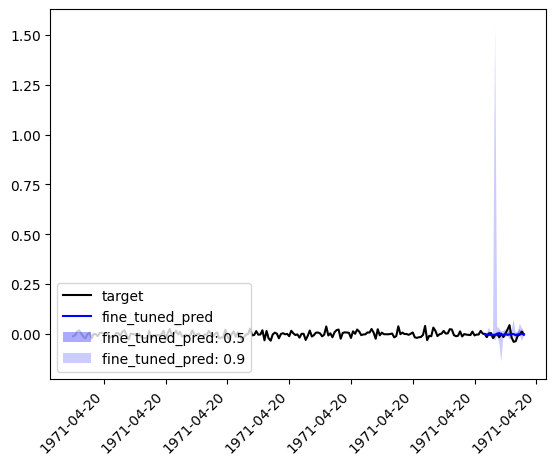

In [9]:
# 8. Plot a single window
print("Plotting a sample forecast...")
inp      = next(iter(test_instances.input))
label    = next(iter(test_instances.label))
forecast = next(iter(forecasts))

plot_single(
    inp,
    label,
    forecast,
    context_length=context_length,
    name="fine_tuned_pred",
    show_label=True,
)
plt.show()

Plotting a sample forecast...


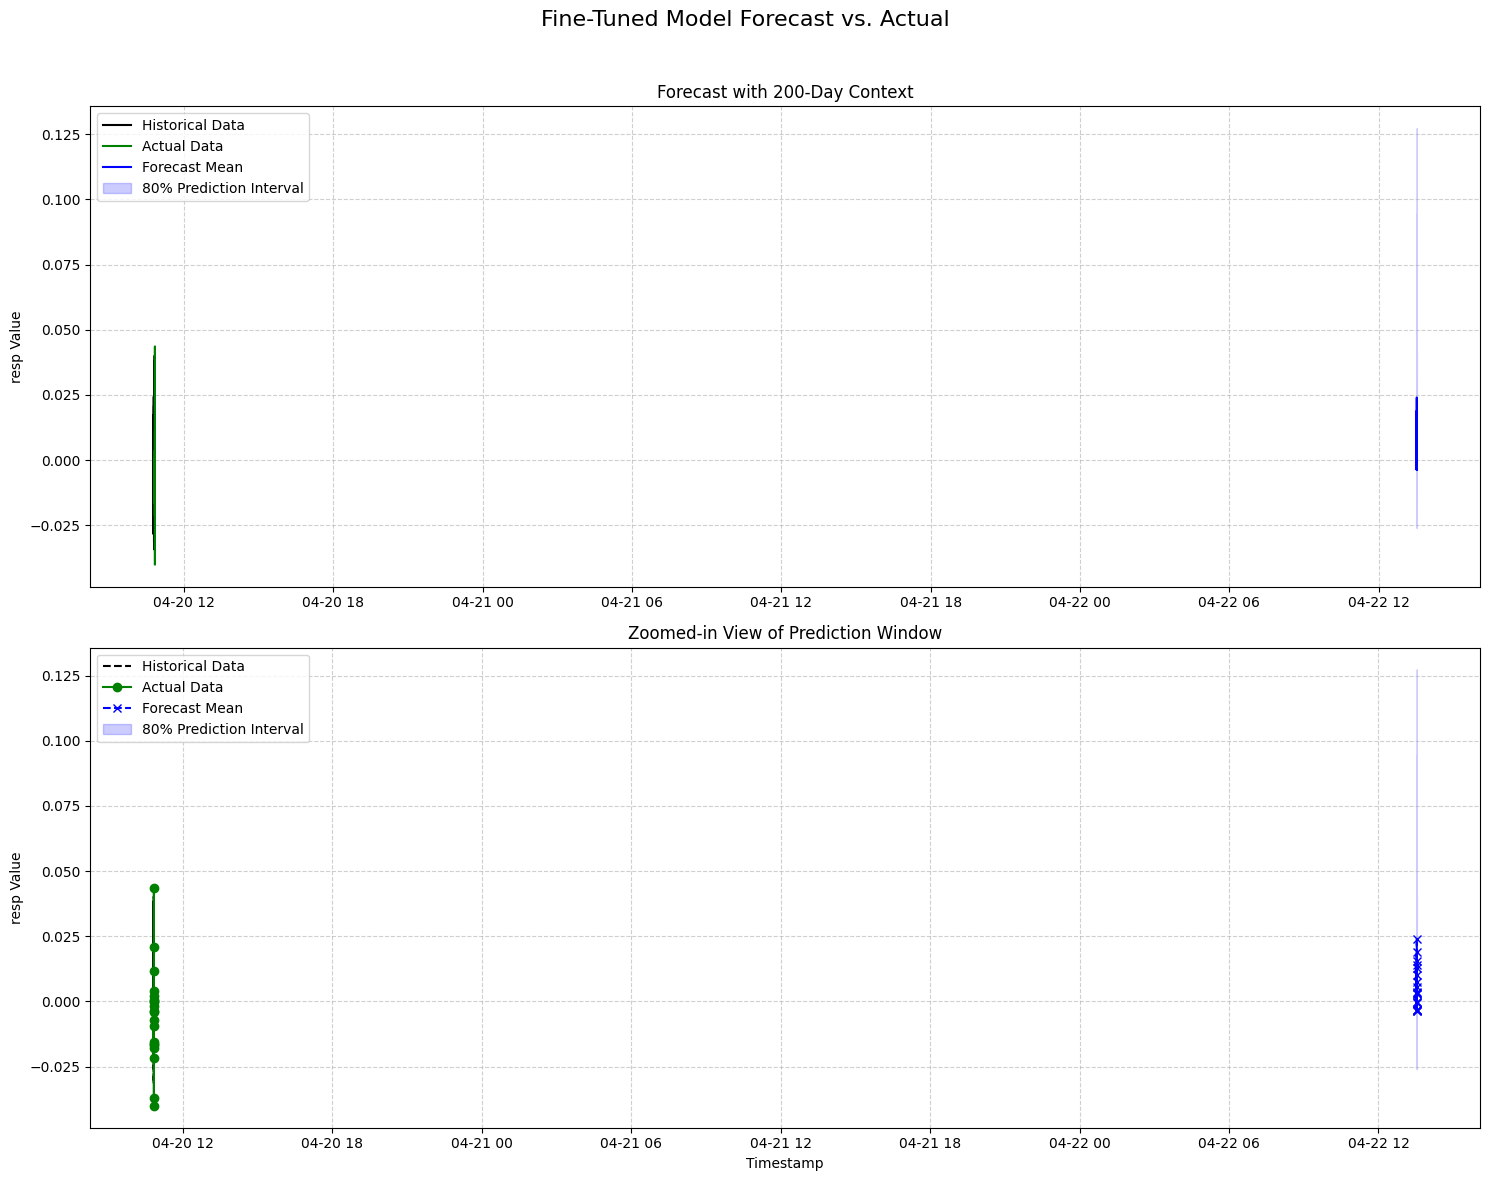

In [11]:
import pandas as pd

# 8. Plot a single window
print("Plotting a sample forecast...")
inp      = next(iter(test_instances.input))
label    = next(iter(test_instances.label))
forecast = next(iter(forecasts))

# --- Custom Plotting Code for Better Analysis ---

# 1. Extract data from GluonTS objects
# We take the last `context_length` points of history for plotting
history = inp['target'][-context_length:]
history_start = inp['start'] + (len(inp['target']) - context_length)
history_index = pd.date_range(
    start=history_start.to_timestamp(),
    periods=len(history),
    freq=history_start.freq
)

label_target = label['target']
label_index = pd.date_range(
    start=label['start'].to_timestamp(),
    periods=len(label_target),
    freq=label['start'].freq
)

forecast_mean = forecast.mean
forecast_p10 = forecast.quantile(0.1)
forecast_p90 = forecast.quantile(0.9)
forecast_index = pd.date_range(
    start=forecast.start_date.to_timestamp(),
    periods=len(forecast_mean),
    freq=forecast.start_date.freq
)

# 2. Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=False)
fig.suptitle('Fine-Tuned Model Forecast vs. Actual', fontsize=16)

# --- Plot 1: Forecast with Historical Context ---
ax1.plot(history_index, history, color='black', label='Historical Data')
ax1.plot(label_index, label_target, color='green', label='Actual Data')
ax1.plot(forecast_index, forecast_mean, color='blue', label='Forecast Mean')
ax1.fill_between(
    forecast_index, forecast_p10, forecast_p90,
    color='blue', alpha=0.2, label='80% Prediction Interval'
)
ax1.set_title(f'Forecast with {context_length}-Day Context')
ax1.set_ylabel('resp Value')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

# --- Plot 2: Zoomed-in View of the Prediction Window ---
zoom_history_points = 50  # Number of historical points to show for context
ax2.plot(history_index[-zoom_history_points:], history[-zoom_history_points:], color='black', linestyle='--', label='Historical Data')
ax2.plot(label_index, label_target, color='green', marker='o', linestyle='-', label='Actual Data')
ax2.plot(forecast_index, forecast_mean, color='blue', marker='x', linestyle='--', label='Forecast Mean')
ax2.fill_between(
    forecast_index, forecast_p10, forecast_p90,
    color='blue', alpha=0.2, label='80% Prediction Interval'
)
ax2.set_title('Zoomed-in View of Prediction Window')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('resp Value')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

# 3. Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
plt.show()

Plotting a sample forecast…


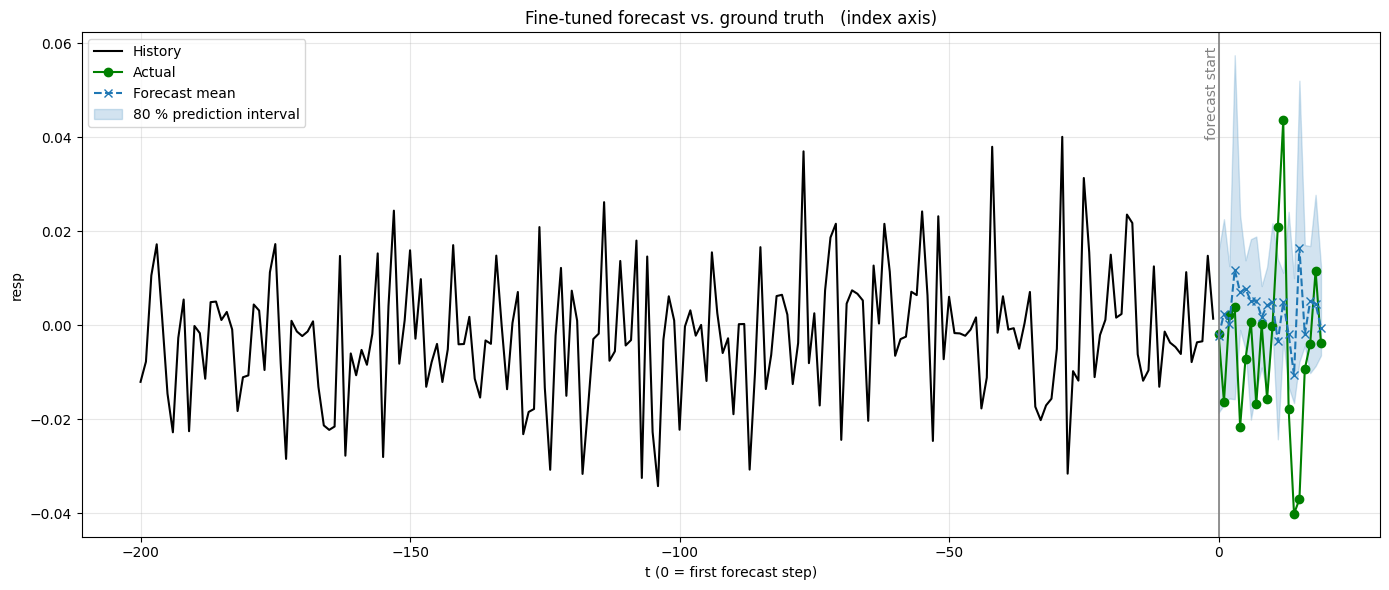

In [12]:
import numpy as np
import matplotlib.pyplot as plt

print("Plotting a sample forecast…")
inp      = next(iter(test_instances.input))
label    = next(iter(test_instances.label))
forecast  = next(iter(forecasts))

# ------------------------------------------------------------------
# 1) Build X-axes that are **indices**, not dates
# ------------------------------------------------------------------
ctx_len  = context_length                 # 200 in your notebook
pred_len = prediction_length              # 20 in your notebook
hist_x   = np.arange(-ctx_len, 0)         # …-200 …-1
pred_x   = np.arange(0,  pred_len)        # 0 … 19  (0 = forecast start)

hist_y   = inp["target"][-ctx_len:]       # last 200 points of history
label_y  = label["target"]                # ground-truth for horizon
fc_mean  = forecast.mean
fc_p10   = forecast.quantile(0.1)
fc_p90   = forecast.quantile(0.9)

# ------------------------------------------------------------------
# 2) Make a single, compact plot (integer axis + reference line)
# ------------------------------------------------------------------
plt.figure(figsize=(14, 6))
plt.title("Fine-tuned forecast vs. ground truth   (index axis)")

# Historical context
plt.plot(hist_x, hist_y,  color="black", label="History")

# Ground truth & prediction
plt.plot(pred_x, label_y,  "o-",  color="green", label="Actual")
plt.plot(pred_x, fc_mean,  "x--", color="tab:blue", label="Forecast mean")
plt.fill_between(pred_x, fc_p10, fc_p90, color="tab:blue", alpha=0.2,
                 label="80 % prediction interval")

# Visual cues
plt.axvline(0, color="grey", linewidth=1.2)           # forecast start
plt.text(0, plt.ylim()[1]*0.95, "forecast start",     # annotate the line
         rotation=90, va="top", ha="right", color="grey")
plt.xlabel("t (0 = first forecast step)")
plt.ylabel("resp")
plt.grid(alpha=.3)
plt.legend()
plt.tight_layout()
plt.show()

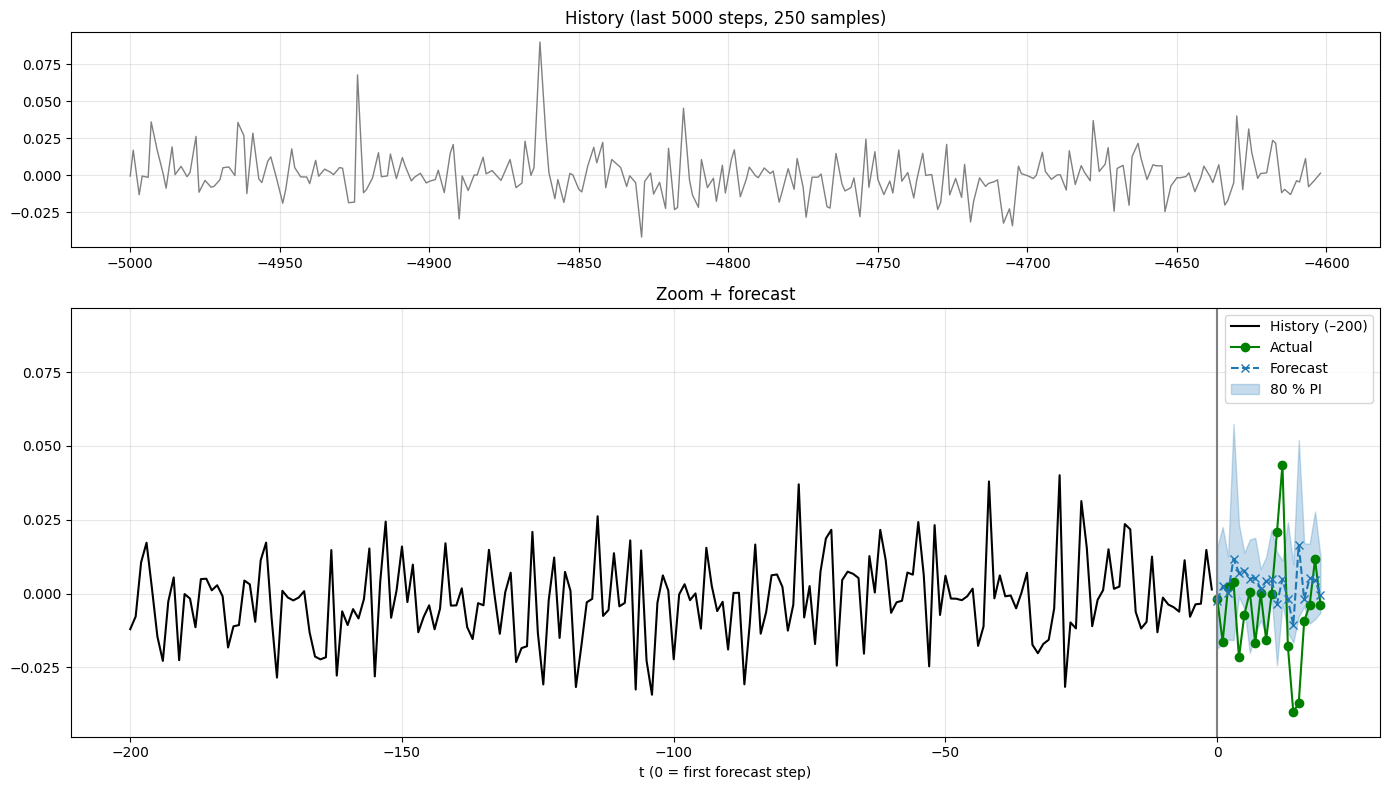

In [14]:
fig, (ax_long, ax_detail) = plt.subplots(2, 1, figsize=(14, 8),
                                         sharey=True,  # same y-axis
                                         gridspec_kw={"height_ratios": [1, 2]})

# --- LONG TREND (top) --------------------------------------------
full_ctx_len   = 5_000
display_points = 250
long_hist = inp["target"][-full_ctx_len:]
keep      = np.linspace(0, len(long_hist)-1, display_points, dtype=int)
ax_long.plot(-full_ctx_len + keep, long_hist[keep],
             color="grey", lw=1.0)
ax_long.set_title(f"History (last {full_ctx_len} steps, {display_points} samples)")
ax_long.grid(alpha=.3)

# --- DETAIL + FORECAST (bottom) ----------------------------------
ctx_len   = context_length
pred_len  = prediction_length
hist_x    = np.arange(-ctx_len, 0)
hist_y    = inp["target"][-ctx_len:]
pred_x    = np.arange(0, pred_len)

ax_detail.plot(hist_x, hist_y, color="black", label=f"History (–{ctx_len})")
ax_detail.plot(pred_x, label["target"], "o-",  color="green", label="Actual")
ax_detail.plot(pred_x, forecast.mean,  "x--", color="C0",    label="Forecast")
ax_detail.fill_between(pred_x,
                       forecast.quantile(0.1), forecast.quantile(0.9),
                       color="C0", alpha=.25, label="80 % PI")
ax_detail.axvline(0, color="grey")
ax_detail.set_title("Zoom + forecast")
ax_detail.set_xlabel("t (0 = first forecast step)")
ax_detail.legend()
ax_detail.grid(alpha=.3)

plt.tight_layout()
plt.show()

In [15]:
len(inp["target"])

399